In [1]:
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
from astropy import units as u
from ccdproc import CCDData, Combiner,combine
import os
from glob import glob
from astropy import stats
from astropy.stats import sigma_clip, mad_std
from astropy.stats import sigma_clipped_stats
from matplotlib.colors import LogNorm
import datetime
from ccdproc import ImageFileCollection
from ccdproc.utils.sample_directory import sample_directory_with_files

import warnings
warnings.filterwarnings('ignore')

In [2]:
directory=  '/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/'

%cd /Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/

filelist = !ls *.fits

/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned


In [3]:
%cd /Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/

from pathlib import Path

filelist = list(sorted(glob('A_*.fits')))
print(f'Total number of files: {len(filelist)}')
print(filelist[0:2])    # printing only from 10 to 19

/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned
Total number of files: 32
['A_N2.20150131.30898_drp.fits', 'A_N2.20150131.31042_drp.fits']


In [4]:
HDUList_object = fits.open(filelist[2])
HDUList_object.info()

Filename: A_N2.20150131.31126_drp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     266   (1024, 1024)   float32   


In [5]:
primary_HDU = HDUList_object[0]

In [6]:
# Extract primary header
primary_header = primary_HDU.header

In [7]:
HDUList_object.close()

In [8]:
from ccdproc import ImageFileCollection
from ccdproc.utils.sample_directory import sample_directory_with_files
from astropy.wcs import WCS
from mpl_toolkits.axes_grid1 import make_axes_locatable
import astroalign as aa #(11.5 cuaderno de examples)
from reproject import reproject_interp 

In [9]:
# auxiliary function to display a rectangle and compute mean value within it
def draw_rectangle(ax, image_data, x1, x2, y1, y2, color, text=False):
    ax.plot((x1, x1), (y1, y2), color, lw=1)
    ax.plot((x2, x2), (y1, y2), color, lw=1)
    ax.plot((x1, x2), (y1, y1), color, lw=1)
    ax.plot((x1, x2), (y2, y2), color, lw=1)
    if text:
        media = image_data[y1:y2,x1:x2].mean()
        std   = image_data[y1:y2,x1:x2].std()
        ax.text((x1+x2)/2, y1+(y2-y1)/8, str(int(media)), 
                ha='center', va='center', color=color, fontsize=12)        
        ax.text((x1+x2)/2, y2-(y2-y1)/8, str(round(std,1)), 
                ha='center', va='top', color=color, fontsize=12)
    return media, std

-----------

Uncomment the following only if we want to separate them per night:

In [10]:
#keys = ['imagetyp','OBJECT' , 'EXPTIME' , 'INSFLID' , 'INSFLNAM','FILTER','DATE-OBS']
#ic1 = ImageFileCollection(directory, glob_include='*.fits', keywords=keys)

In [11]:
#matches = (ic1.summary['DATE-OBS'] =='2015-02-04' ) #replace with the desired date

In [12]:
#filelist = ic1.summary['file'][matches]

-------------

continue

In [13]:
image_K=[]
headers_K=[]
for i in filelist:
    imagen = fits.open(str(i))[0]
    image_K.append(imagen)
    headers_K.append(imagen.header)

0 -179 154
1 -182 146
2 -189 149


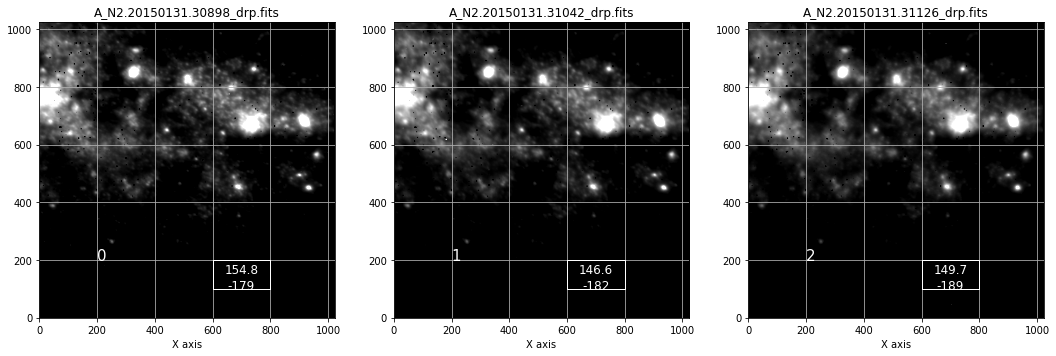

In [14]:
sky_mean , std = [] , []
fig, axarr = plt.subplots(ncols=3, nrows=1, figsize=(18, 18))
for n in range(3):
    ax = axarr[n]
    ax.imshow(image_K[n].data, cmap='gray', origin='lower',vmin=100, vmax=2000)
    ax.text(200,200,n,fontsize=15,color="w")
    ax.set_xlabel('X axis')
    ax.set_title(str(filelist[n]))
    mean_n,std_n = draw_rectangle(ax, image_K[n].data, 600, 800, 100, 200, color='w',text=True)
    print(n,int(mean_n),int(std_n))
    sky_mean.append(mean_n)
    std.append(std_n)
    ax.grid()

In [15]:
%cd /Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/
image = []
for file in filelist:
    image.append(CCDData.read(file,unit="adu"))

/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned


In [16]:
#combiner = Combiner(image)
#combiner.sigma_clipping(low_thresh=3, use_astropy=True, grow=1)
#scaling_func = lambda arr: 120/np.ma.average(arr[400:600,500:600])
#combiner.scaling = scaling_func 

In [17]:
# mean combine 
#combined_image_average  = combiner.average_combine()
# median combine 
#combined_image_median = combiner.median_combine()
combined_image_average=combine(image, method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
combined_image_average.meta['combined'] = True

In [18]:
#Subtract background
mean_val, median_val, std_val = sigma_clipped_stats(combined_image_average.data, sigma=3)  #Sigma is the number of standard deviations 
    #median_val=np.median(data_K)                                          #to use for both the lower and upper clipping limit.
                                                                           # Default=3
combined_image_average.data -= median_val

#NORMALIZE IF NEEDED
#combined_image_average.data = combined_image_average.data / combined_image_average.data.sum()


In [19]:
# Extract primary header from single file and copy into new combined file header
HDUList_object = image[0].header
combined_image_average.header = HDUList_object

In [20]:
# Replace FILENAME keyword and add information
combined_image_average.header['FILENAME'] = 'M82_X2_combined_K2.fits' 
combined_image_average.header['HISTORY'] = 'average combining '+ str(32) + 'images'

In [21]:
%cd /Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/Normalized/Combined/
combined_image_average.write('M82_X2_combined_K2.fits',overwrite='yes')

/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/Normalized/Combined
